In [4]:
import torch
from utils.gaussian_diffusion import GaussianDiffusion
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./../data', train=True, download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./../data', train=False, download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

diffusion = GaussianDiffusion(img_size=(3, 32, 32), timesteps=1000, beta_start=0.0001, beta_end=0.02, device='cpu')

data_iter = iter(trainloader)
images, labels = next(data_iter)
images = images.to('cpu')

t = torch.randint(0, diffusion.timesteps, (images.size(0),), device='cpu').long()
x_t, noise = diffusion.forward_diffusion(images, t)

print(f"Input shape: {images.shape}")
print(f"Noisy shape: {x_t.shape}")

Input shape: torch.Size([32, 3, 32, 32])
Noisy shape: torch.Size([32, 3, 32, 32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.29575253..1.6100066].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.47492015..1.6081772].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5346656..1.5471675].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5655204..1.339441].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.54562974..1.4173194].


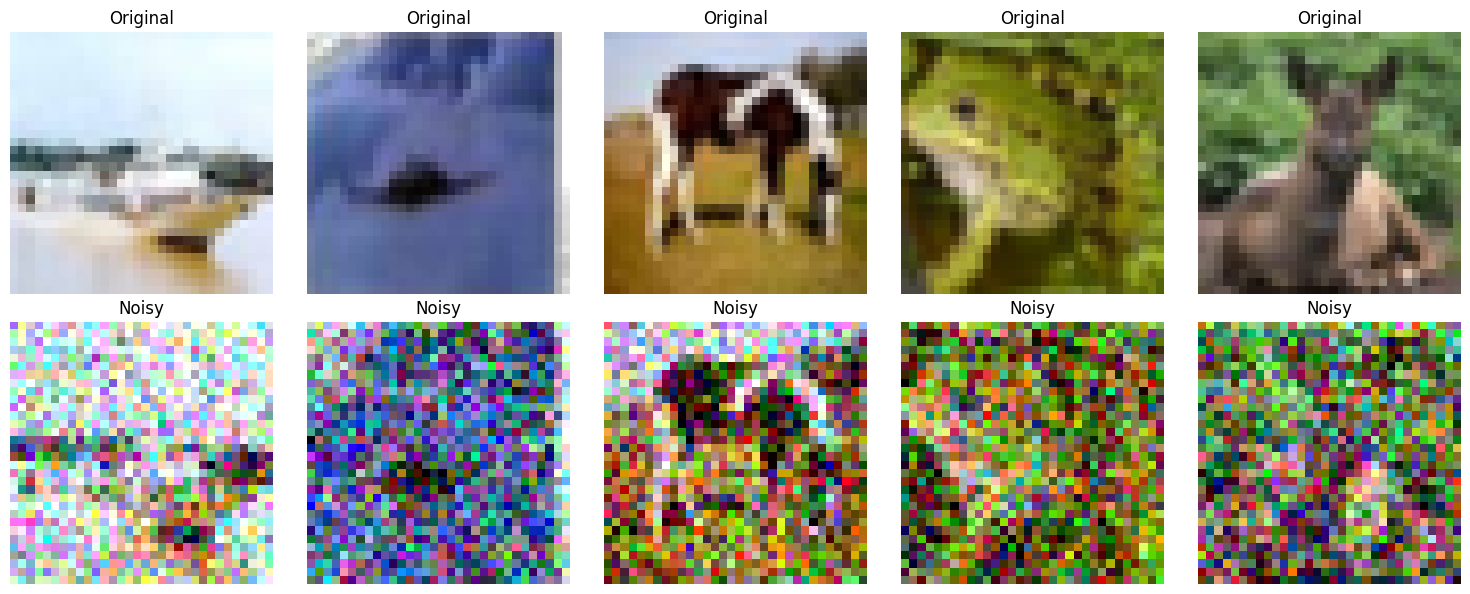

In [13]:
from utils.visualization import visualize_noisy_samples

data_iter = iter(trainloader)
images, labels = next(data_iter)
images = images.to('cpu')

t = 150
noisy_images, noise = diffusion.forward_diffusion(images, t)

visualize_noisy_samples(images, noisy_images, num_samples=5)